In [9]:
import pandas as pd
import streamlit as st

# Example for Google Drive
url = "https://drive.google.com/uc?export=download&id=19DYVjBV8Nlw_bsvtH0q67GdHIh70z8Z-"

@st.cache_data
def load_data():
    df = pd.read_csv(url)
    return df

df = load_data()
st.write(df.head())
df = pd.read_excel("F:/Parami/Courses/2025_Fall/Advanced_ML/Assignments/online_retail/OnlineRetail.xlsx")

# --- Data Preprocessing ---
df.drop_duplicates() # Remove duplicates
df = df.dropna(subset=['CustomerID']) # Remove rows with no Customer ID
df['InvoiceNo'] = df['InvoiceNo'].astype(str) # Change invoice no. to string 
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')] # Remove cancelled transaction 
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)] # Remove transaction with no or negative quantity and unit price
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) # Change invoice date into date format

df['TotalPrice'] = df['Quantity'] * df['UnitPrice'] # Total amount of money spent by each customer

print(df.head())
print(df.isnull().sum())

2025-05-05 10:06:55.847 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-05-05 10:06:56.376 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-05-05 10:06:56.379 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 10:07:30.405 
  command:

    streamlit run c:\Users\ACER\anaconda3\envs\machinelearning_env\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-05 10:07:30.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 10:07:30.416 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 10:07:30.973 Thread 'Thread-7': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-05 10:07:31.377 Threa

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     

In [10]:
df.count()

InvoiceNo      397884
StockCode      397884
Description    397884
Quantity       397884
InvoiceDate    397884
UnitPrice      397884
CustomerID     397884
Country        397884
TotalPrice     397884
dtype: int64

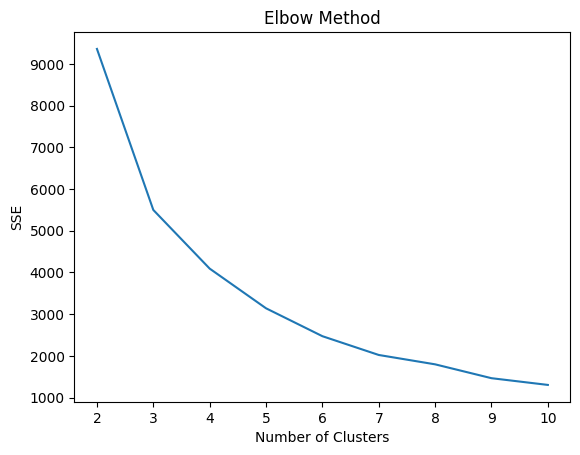

In [11]:
# --- Feature Engineering for clustering (Using RFM Model) ---

import datetime as dt
latest_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Grouping RFM features by Cus ID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': lambda x: (df.loc[x.index, 'Quantity'] * df.loc[x.index, 'UnitPrice']).sum()
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Normalize RFM features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# --- Clustering with K-Means ---

# Determining optimal K

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    sse.append(km.inertia_)

plt.plot(range(2, 11), sse)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

In [12]:
# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
print(rfm.head())

# Inverse scaling for interpretability
cluster_centers_scaled = kmeans.cluster_centers_ 
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=['Recency', 'Frequency', 'Monetary'])
print(cluster_centers_df.head())

# Get cluster labels and medoids
cluster_labels = kmeans.labels_
medoids = kmeans.cluster_centers_

            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         326          1  77183.60        1
12347.0           2          7   4310.00        0
12348.0          75          4   1797.24        0
12349.0          19          1   1757.55        0
12350.0         310          1    334.40        1
      Recency  Frequency       Monetary
0   40.983906   4.852677    2012.111620
1  246.023788   1.582800     631.141410
2    7.142857  80.214286  122888.407143


In [ ]:
import pickle

def label_rfm_cluster(recency, frequency, monetary):
    if recency <= 30 and frequency >= 15 and monetary >= 1000:
        return "Loyal Big Spenders"
    elif recency > 90 and frequency < 5 and monetary < 500:
        return "At-Risk Low Spenders"
    elif recency <= 60 and frequency >= 10 and monetary >= 700:
        return "Potential Loyalists"
    elif recency > 120 and frequency < 3:
        return "Lost Customers"
    elif recency < 15 and frequency < 5 and monetary < 200:
        return "New or Impulsive"
    else:
        return "Average Buyers"

# Generate labels for each cluster
cluster_labels = {}
for i, center in enumerate(cluster_centers_original):
    recency, frequency, monetary = center
    label = label_rfm_cluster(recency, frequency, monetary)
    cluster_labels[i] = label

rfm['Cluster_Label'] = rfm['Cluster'].map(cluster_labels)

with open('cluster_labels.pkl', 'wb') as f:
    pickle.dump(cluster_labels, f)

In [14]:
# --- Classification Using Random Forest ---
import pickle

# Prepare data
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Cluster']

# Spliting training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train random forest classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Save the model and scaler for deployment
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)
print("Confusion_Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nInitial Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("\nValue frequencies:") # Freq of each unique value
print(y.value_counts()) # The test results of Class 2 is sensitive since the data is small and unbalanced

Confusion_Matrix:
[[633   2   0]
 [  0 229   0]
 [  1   0   3]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       635
           1       0.99      1.00      1.00       229
           2       1.00      0.75      0.86         4

    accuracy                           1.00       868
   macro avg       1.00      0.92      0.95       868
weighted avg       1.00      1.00      1.00       868


Initial Accuracy Score:
0.9965437788018433

Value frequencies:
Cluster
0    3231
1    1093
2      14
Name: count, dtype: int64


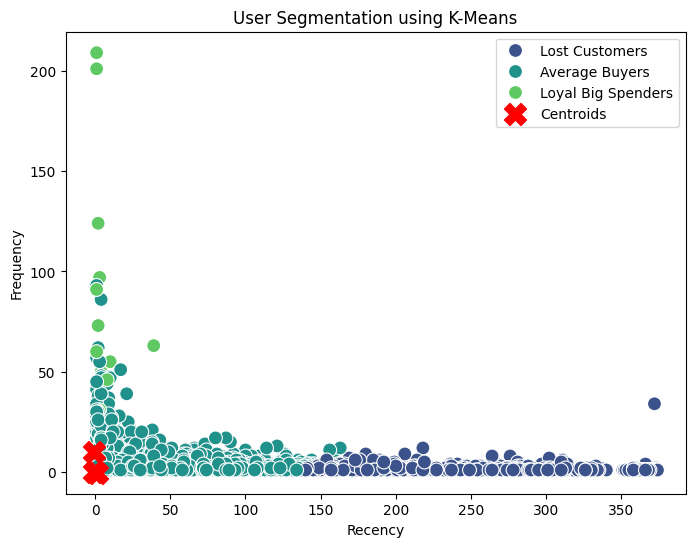

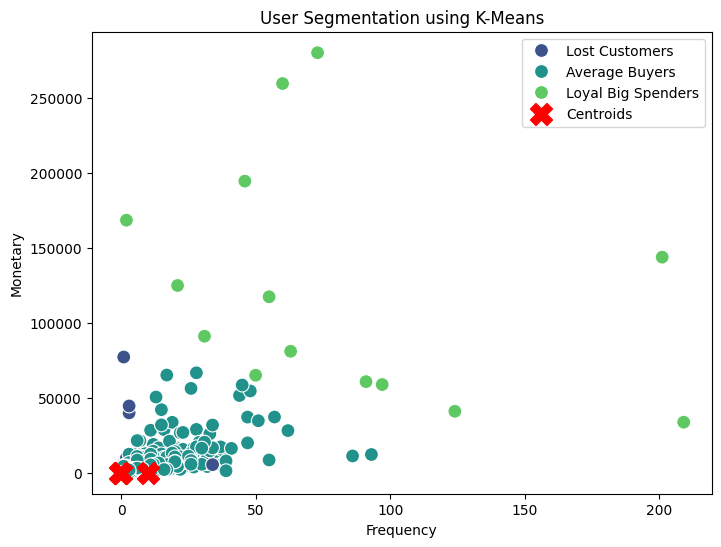

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Frequency'], hue=rfm['Cluster_Label'], palette='viridis', s=100)
plt.scatter(medoids[:, 0], medoids[:, 1], s=250, c='red', marker='X', label='Centroids')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('User Segmentation using K-Means')
plt.legend()
plt.show()

# Visualizing the Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm['Frequency'], y=rfm['Monetary'], hue=rfm['Cluster_Label'], palette='viridis', s=100)
plt.scatter(medoids[:, 1], medoids[:, 2], s=250, c='red', marker='X', label='Centroids')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('User Segmentation using K-Means')
plt.legend()
plt.show()